In [62]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(PROJECT_ROOT)
import helpers as db
cursor = db.connect_to_db()
cursor.execute("SELECT table_schema,table_name FROM information_schema.tables ORDER BY table_schema,table_name;")



In [63]:
# getting global temperatures lastdecade from the max date of reporting  (2015-09-01)
def global_temperatures_decade():
    cursor.execute(
    "SELECT *,(date_part('year','2015-12-01'::date)-date_part('year',dt::date)) as lastdecade FROM import.globaltemperatures where (date_part('year','2015-12-01'::date)-date_part('year',dt::date))<=10;"
)
    #return dataframe
    return pd.DataFrame(cursor.fetchall(), columns=[x[0] for x in cursor.description])

  


In [64]:
# Global temperatures in the last century -  (2015-09-01) is the maximum year..

def global_temperatures_last_century():
    cursor.execute(
        "SELECT * FROM import.globaltemperatures where (date_part('year','2015-12-01'::date)-date_part('year',dt::date))<=100;"
    )
    #return dataframe
    return pd.DataFrame(cursor.fetchall(), columns=[x[0] for x in cursor.description])


In [65]:
# temperatures by the top 5 countries in the last century: Higest pollutors = United States, China, Russia, India, Japan
def temperatures_of_top5():
    cursor.execute(
    "SELECT * FROM import.globaltemperaturesbycountry where (date_part('year','2015-12-01'::date)-date_part('year',dt::date))<=100 and country in ('United States','China','Russia','India','Japan');"
)
    #return dataframe
    return pd.DataFrame(cursor.fetchall(), columns=[x[0] for x in cursor.description])


In [66]:
# add a column for highest pollutors by season.
# usa: winter = 12,1,2, spring = 3,4,5, summer = 6,7,8, fall = 9,10,11
# Russia: winter = 11,12,1,2,3, spring = 4,5 summer = 6,7,8 autumn = 9,10
# china: winter =12,1,2 sprint = 3,4,5 summer = 06,7,8 autum = 9,10,11
# india: winter = 12,1 spring = 2,3 summer = 4,5,6 monsoon 7,8,9(01-15th), autum =9,(15th -) 10,11
# japan: winter = 12,1,2 spring = 3,4,5 summer = 6,7,8 autumn = 9,10,11


def add_season_column():
    cursor.execute(
        "ALTER TABLE import.globaltemperaturesbycountry ADD COLUMN season varchar(10);"
    )
    cursor.execute(
        "UPDATE import.globaltemperaturesbycountry SET season = 'winter' WHERE (date_part('month',dt::date) in (12,1,2) and country = 'United States') or (date_part('month',dt::date) in (11,12,1,2,3) and country = 'Russia') or (date_part('month',dt::date) in (12,1,2) and country = 'China') or (date_part('month',dt::date) in (12,1) and country = 'India') or (date_part('month',dt::date) in (12,1,2) and country = 'Japan');"
    )
    cursor.execute(
        "UPDATE import.globaltemperaturesbycountry SET season = 'spring' WHERE (date_part('month',dt::date) in (3,4,5) and country = 'United States') or (date_part('month',dt::date) in (4,5) and country = 'Russia') or (date_part('month',dt::date) in (3,4,5) and country = 'China') or (date_part('month',dt::date) in (2,3) and country = 'India') or (date_part('month',dt::date) in (3,4,5) and country = 'Japan');"
    )
    cursor.execute(
        "UPDATE import.globaltemperaturesbycountry SET season = 'summer' WHERE (date_part('month',dt::date) in (6,7,8) and country = 'United States') or (date_part('month',dt::date) in (6,7,8) and country = 'Russia') or (date_part('month',dt::date) in (6,7,8) and country = 'China') or (date_part('month',dt::date) in (4,5,6) and country = 'India') or (date_part('month',dt::date) in (6,7,8) and country = 'Japan');"
    )
    cursor.execute(
        "UPDATE import.globaltemperaturesbycountry SET season = 'autumn' WHERE (date_part('month',dt::date) in (9,10) and country = 'Russia') or (date_part('month',dt::date) in (9,10,11) and country = 'China') or (date_part('month',dt::date) in (9,10,11) and country = 'India') or (date_part('month',dt::date) in (9,10,11) and country = 'Japan');"
    )
    cursor.execute(
        "UPDATE import.globaltemperaturesbycountry SET season = 'monsoon' WHERE (date_part('month',dt::date) in (7,8) and country = 'India');"
    )
    cursor.execute(
        "UPDATE import.globaltemperaturesbycountry SET season = 'Fall' where (date_part('month',dt::date) in (9,10,11) and country = 'United States');"
    )
    pass


pass



In [67]:
# create a function to plot the data for last century and decade
def plot_data(data_frame, x, y, title, x_label, y_label):
    data_frame[y] = data_frame[y].astype(float)
    data_frame[x] = pd.to_datetime(data_frame[x])
    # check of the dataset is for the last century or decade
    if data_frame[x].dt.year.max() - data_frame[x].dt.year.min() >= 11:
        data_frame = data_frame.groupby(data_frame[x].dt.year).mean()
        plt.plot(data_frame.index, data_frame[y])
    else:
        # get the moving average for the last decade
        data_frame['movingaverage'] = data_frame[y].rolling(window=1).mean()
        plt.plot(data_frame[x], data_frame['movingaverage'])
        pass
    pass
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    pass

/var/folders/vp/zcr3nqv95xj65cjq_tytggfh0000gq/T/ipykernel_14101/204768041.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_frame = data_frame.groupby(data_frame[x].dt.year).mean()


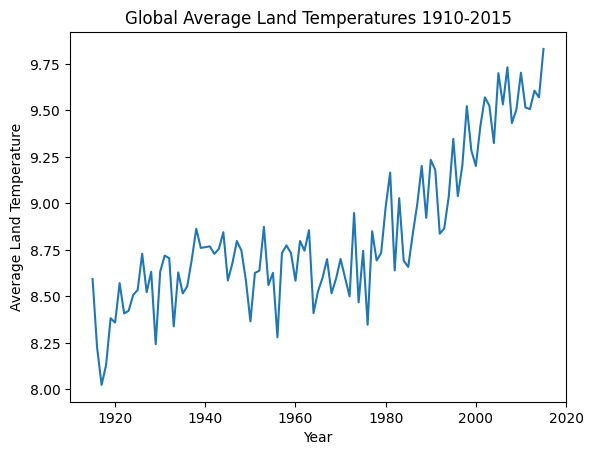

In [68]:
plot_data(global_temperatures_last_century(), 'dt', 'landaveragetemperature', 'Global Average Land Temperatures 1910-2015', 'Year', 'Average Land Temperature')

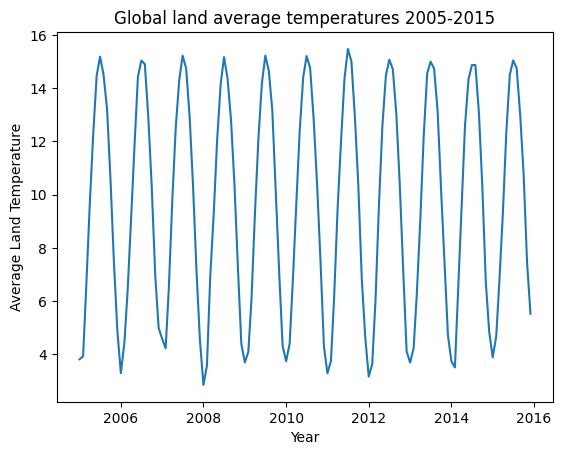

In [69]:
# plot the data for last decade
plot_data(global_temperatures_decade(), 'dt', 'landaveragetemperature', 'Global land average temperatures 2005-2015', 'Year', 'Average Land Temperature')

In [70]:
# view to add season column

add_season_column()

In [71]:

top5 = temperatures_of_top5().copy()
top5['dt'] = pd.to_datetime(top5['dt'])
top5['averagetemperature'] = top5['averagetemperature'].replace('', np.nan)
top5['averagetemperature'] = top5['averagetemperature'].astype(float)
top5['movingaverage'] = top5['averagetemperature'].rolling(window=3).mean()
top5.head(5).sort_values(by='dt', ascending=True)

,dt,averagetemperature,averagetemperatureuncertainty,country,season,movingaverage
1,1928-03-01,-17.189,0.648,Russia,winter,NaN
2,1928-11-01,-17.023,0.68,Russia,winter,-7.127667
3,1928-12-01,-22.889,0.628,Russia,winter,-19.033667
4,1929-01-01,-28.131,0.77,Russia,winter,-22.681000
0,1959-05-01,12.829,0.095,China,spring,NaN


In [72]:
# moving average..
def create_chart(df, country):
    chart = alt.Chart(df).mark_line().encode(
        x=alt.X('dt', title='Year'),
        y=alt.Y('movingaverage', scale=alt.Scale(zero=False), title='moving average Temperature (Celsius)'),
        color=alt.Color('season', title='Season'),
        tooltip=['dt', 'movingaverage', 'season']
    ).properties(
        width=600,
        height=300,
        title=country)
    
    line = chart.transform_regression(
        'dt',
        'movingaverage',
        method='linear',
        as_=['dt', 'movingaverage']
    )
    return chart+line

In [73]:
create_chart(top5[top5['country'] == 'United States'], 'United States') | create_chart(top5[top5['country'] == 'Russia'], 'Russia') | create_chart(top5[top5['country'] == 'China'], 'China') | create_chart(top5[top5['country'] == 'India'], 'India') | create_chart(top5[top5['country'] == 'Japan'], 'Japan')

/opt/miniconda3/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.HConcatChart(...)

In [74]:
# trying to collapse the dataset by country and season and year..
def create_chart_temp(df, country):
    
    chart = alt.Chart(df[df['country'] == country]).mark_line().encode(
        x=alt.X('dt', title='Year'),
        y=alt.Y('averagetemperature', scale=alt.Scale(zero=False), title='Average Temperature (Celsius)'),
        color=alt.Color('season', title='Season'),
    ).properties(
        width=600,
        height=300,
        title=country
    )
    return chart

In [75]:
# collapse the dataset by year, season and take the averagetemperature and see if it makes sense..
top_collapsed = top5.groupby(['dt', 'season', 'country']).mean().reset_index()
top_collapsed
create_chart_temp(top_collapsed, 'United States') | create_chart_temp(top_collapsed, 'Russia') | create_chart_temp(top_collapsed, 'China') | create_chart_temp(top_collapsed, 'India') | create_chart_temp(top_collapsed, 'Japan')

/var/folders/vp/zcr3nqv95xj65cjq_tytggfh0000gq/T/ipykernel_14101/2973260411.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_collapsed = top5.groupby(['dt', 'season', 'country']).mean().reset_index()
/opt/miniconda3/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.HConcatChart(...)